In [12]:
# Setup

%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import matplotlib.pyplot as plt
import torch
import numpy as np

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [13]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])
    

# Prior and Decoder

In [14]:
single_galaxy_prior = instantiate(cfg.datasets.galsim_blended_std_psf.prior.single_galaxy_prior)
single_star_prior = instantiate(cfg.datasets.galsim_blended_std_psf.prior.single_star_prior)
single_galaxy_decoder = instantiate(cfg.datasets.galsim_blended_std_psf.decoder.single_galaxy_decoder)
single_star_decoder = instantiate(cfg.datasets.galsim_blended_std_psf.decoder.single_star_decoder)

In [15]:
from case_studies.psf_homogenization.galsim_star import UniformGalsimPrior
prior = UniformGalsimPrior(single_galaxy_prior, single_star_prior, max_n_sources=5, max_shift=0.5, galaxy_prob=0.0)

In [18]:
# check samples look OK 
sample = prior.sample()

# COMMENT OUT for checking what happens when two sources fall in one tile
# sample['locs'][1, :] = sample['locs'][0, :] + 0.01
print(sample)


{'n_sources': tensor(3), 'galaxy_params': tensor([[2.0232e+04, 7.3690e-01, 3.2358e+00, 9.0207e-01, 9.5904e-01, 3.6849e-01,
         4.5247e+00],
        [1.7982e+03, 6.6057e-01, 1.7810e+00, 3.9334e-01, 8.5610e-01, 8.2687e-01,
         4.5711e-01],
        [4.2673e+04, 9.9399e-01, 3.5179e+00, 7.1620e-02, 8.4392e-01, 8.5388e-01,
         6.7176e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]]), 'star_params': tensor([[ 882.1273],
        [1291.4325],
        [9035.8320],
        [   0.0000],
        [   0.0000]]), 'locs': tensor([[0.1686, 0.5101],
        [0.3656, 0.4577],
        [0.5371, 0.2107],
        [0.0000, 0.0000],
        [0.0000, 0.0000]]), 'galaxy_bools': tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.]]), 'star_bools': tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.]])}


In [6]:
# now load full decoder
from case_studies.psf_homogenization.galsim_star import FullCatelogDecoderSG
slen = 40
bp = 24
decoder = FullCatelogDecoderSG(single_galaxy_decoder, single_star_decoder, slen, bp)

In [7]:
# turn sample to FullCatalog
from bliss.catalog import FullCatalog
params_dict = {**sample}
params_dict["plocs"] = params_dict["locs"] * slen
params_dict.pop('locs')
params_dict = {k: v.unsqueeze(0) for k, v in params_dict.items()}
full_cat = FullCatalog(slen, slen, params_dict)
print(full_cat['galaxy_bools'].shape)
print(full_cat['star_bools'].shape)
print(full_cat.n_sources)

torch.Size([1, 5, 1])
torch.Size([1, 5, 1])
tensor([5])


In [8]:
tile_slen = 4
max_tile_n_sources = 1
tile_cat = full_cat.to_tile_params(tile_slen, max_tile_n_sources, ignore_extra_sources=True)
tile_cat['galaxy_bools'].shape

torch.Size([1, 10, 10, 1, 1])

In [9]:
images, centered, uncentered = decoder(full_cat)

In [10]:
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')

In [11]:
# tiles (blue squares)
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')
for x,y in zip(np.arange(0, slen+tile_slen, tile_slen) + bp, np.arange(0, slen+tile_slen, tile_slen) + bp): 
    plt.axvline(x, c='cyan', alpha=0.5)
    plt.axhline(y, c='cyan', alpha=0.5)

In [12]:
tile_cat.n_sources # should correspond to above squares

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [13]:
tile_cat['galaxy_params'][0, :, :, 0, 0] # should correspond to above squares as well

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [929.1895,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,

In [14]:
# check images for metrics
plt.imshow(centered[2, 0].numpy())

In [15]:
plt.imshow(uncentered[2, 0].numpy())

# Dataset

In [29]:
# now dataset 
from case_studies.psf_homogenization.galsim_blends_sg import GalsimBlendsSGwithPSF, PsfSampler
from bliss.datasets.background import ConstantBackground
background = ConstantBackground((860.,))
psf_sampler = PsfSampler(2.5, 5)
ds = GalsimBlendsSGwithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=5, psf_sampler=psf_sampler, std_psf_fwhm=0.5)

In [24]:
# get one sample from dataset
print(ds[0]['galaxy_bools'].shape)
print(ds[0]['star_bools'].shape)
print(ds[0]['n_sources'])

torch.Size([10, 10, 1, 1])
torch.Size([10, 10, 1, 1])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


torch.Size([5, 10, 10])
torch.Size([5, 1, 88, 88])
torch.Size([5, 10, 10, 1, 1])
torch.Size([5, 10, 10, 1, 1])

torch.Size([5, 10, 10])
torch.Size([5, 1, 88, 88])
torch.Size([5, 10, 10, 1, 1])
torch.Size([5, 10, 10, 1, 1])

torch.Size([5, 10, 10])
torch.Size([5, 1, 88, 88])
torch.Size([5, 10, 10, 1, 1])
torch.Size([5, 10, 10, 1, 1])

torch.Size([5, 10, 10])
torch.Size([5, 1, 88, 88])
torch.Size([5, 10, 10, 1, 1])
torch.Size([5, 10, 10, 1, 1])

torch.Size([5, 10, 10])
torch.Size([5, 1, 88, 88])
torch.Size([5, 10, 10, 1, 1])
torch.Size([5, 10, 10, 1, 1])



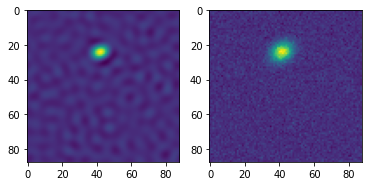

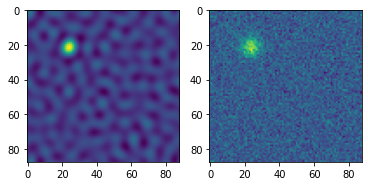

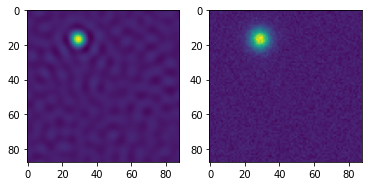

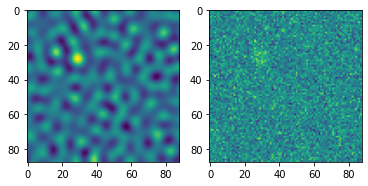

In [30]:
# now a batch and draw example images
for x in ds.train_dataloader():
    print(x['n_sources'].shape)
    print(x['images'].shape)
    print(x['snr'].shape)
    print(x['galaxy_bools'].shape)
    print()
    plt.figure()
    plt.subplot(121)
    plt.imshow(x['images'][0, 0].numpy()) # plot first figure of each batch.
    plt.subplot(122)
    plt.imshow(x['noisy_image'][0, 0].numpy())
plt.close()

In [19]:
# looks like we are ready to go :)